<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 20px; height: 55px">


# Hanzi Hero: Empowering Kids to Master Chinese Characters
# Deployment to Streamlit Cloud
### DSI-SG-42 Jayme Zhang

---

Note: This notebook is built upon `06_Self_Trained_Model_Multiclass_HP_Tune` from the repository `hanzi_hero`. This model is trained on 14 single Chinese characters indicated in this [sample spelling list](sample_spelling_lists/P1_week_6_spelling_list.png) obtained from a local MOE school's [website](https://www.punggolcovepri.moe.edu.sg/for-parents/Subject-Downloads/mother-tongue-spelling-list/), for the sole purpose of deploying to Streamlit Cloud.

In [47]:
# Import libraries and modules
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, GlobalMaxPooling2D, Activation
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import utils
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard

import keras as keras
from keras import layers, initializers
from keras.preprocessing.image import ImageDataGenerator
from keras_tuner.tuners import RandomSearch

import time
import datetime, os
import json

In [15]:
tf.keras.backend.clear_session()

### 1.1 Basic Setup

#### 1.1.1 Set random seed

For easy comparison of results and debugging purposes, we will set up the following to ensure reproducibility of results.

In [16]:
# To ensure reproducibility of results
keras.utils.set_random_seed(42)
tf.config.experimental.enable_op_determinism()

#### 1.1.2 Set font for output of Chinese characters

Since our labels include Chinese characters, for the characters to be displayed correctly on visualisations, we will set the fonts to be compatible.

In [17]:
# To check if the Chinese font for Simplified Chinese Songti is available
print([f for f in fm.fontManager.ttflist if 'Songti' in f.name])

[FontEntry(fname='/System/Library/Fonts/Supplemental/Songti.ttc', name='Songti SC', style='normal', variant='normal', weight=900, stretch='normal', size='scalable')]


In [18]:
# To display Chinese characters in matplotlib
plt.rcParams['font.family'] = ['Songti SC']

### 1.2 Image Augmentation

We will be augmenting the images in the following ways:

1. We will rescale the image's pixels from between 0 to 255, to between 0.0 to 1.0, by dividing by 255. This would be a more direct and efficient approach compared to using StandardScalar().
  
2. The image can be rotated through any degree between 0 and 360. We will rotate the images by 10 degrees as there could be handwriting styles which are slanted to either left or right.

3. When the image is rotated, some pixels will move outside the image and leave an empty area that needs to be filled in. The default value of 'nearest' will simply replace the empty area with the nearest pixel values.
  
4. To account for scenarios when the object may not always be in the centre of the image, we can shift the pixels of the image either horizontally or vertically. If the value is a float, that would represent the percentage of width or height of the image to shift. If it is an integer value, the width or height would shifted by that value of pixel values. In our case, we will shift it by 20%.

5. Shear transformation is a process of slanting the image. It is different from the rotation because in rotation we will rotate the image. But for shearing, we fix one axis and stretch the image in a certain angle known as the shearing angle. The value will be float which represents a shear angle in a counter-clockwise direction in degrees. We will shear by 20%.

6. The zoom augmentation will zoom in on the image for values smaller than 1, and zoom out on the image for values greater than 1. We will zoom in by 10%.

In [19]:
# Augmentation for training data
train_data = ImageDataGenerator(
    rescale=1./255, # normalize values to between 0 and 1
    rotation_range=10, # rotate image by 10 degrees
    fill_mode='nearest', # replaces empty area with the nearest pixel values
    width_shift_range=0.2, # shifts image width by 20%
    height_shift_range=0.2, # shifts image height by 20%
    shear_range=0.2, # shears image by 20%
    zoom_range=0.1 # zoom in image by 10%
)

# Validation data only requires normalizing of values to between 0 and 1
val_data = ImageDataGenerator(rescale=1./255)

### 1.3 Reading Files from Directory

Since all our dataset are images stored in individual folders, we will use `flow_from_directory` to specify that we want to read all files from a given directory. The directory should be set to the path where the various classes of folders are present.

At the same time, we are able to specify the following settings:

1. Since the images in the dataset are of diferring sizes, we will resize all image to (64, 64).  
  
2. We will set the images to 'grayscale'.

3. There will be 16 images yielded from the generator per batch.  
  
4. For this case, our `class_mode` will be set to categorical.  
  
5. We will set `shuffle` to True so that the order of the image that is being yielded will be shuffled. 

In [20]:
# To read in images from train folder
train_generator = train_data.flow_from_directory(
    '../data/st_data/train',
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=16,
    class_mode='categorical', # categorical for multiclass model
    shuffle=True,
    seed=42
)

# To read in images from validation folder
val_generator = val_data.flow_from_directory(
    '../data/st_data/valid',
    target_size=(64, 64),
    color_mode="grayscale",
    batch_size=16,
    class_mode='categorical', # categorical for multiclass model
    shuffle=False,
    seed=42
)

Found 8389 images belonging to 14 classes.
Found 2003 images belonging to 14 classes.


After reading in the images from the directory, we need to find out the labels allocated for different class.

In [21]:
# To find out labels for the 2 classes
train_generator.class_indices

{'公': 0,
 '口': 1,
 '头': 2,
 '它': 3,
 '我': 4,
 '手': 5,
 '有': 6,
 '狗': 7,
 '目': 8,
 '看': 9,
 '舌': 10,
 '要': 11,
 '走': 12,
 '足': 13}

The results are returned in the form of a dictionary, where the Chinese character is the key and the index of the class is the value.

In [43]:
# Convert all keys into a list
class_labels = [i for i in train_generator.class_indices]
print(class_labels)

['公', '口', '头', '它', '我', '手', '有', '狗', '目', '看', '舌', '要', '走', '足']


In [48]:
# Save class labels to a JSON file
with open('class_labels.json', 'w') as f:
    json.dump(class_labels, f)

### 1.4 Tuning of Hyperparameters

We will be using KerasTuner for the purpose of hyperparameters tuning. It is an open-source library built on top of Keras, and is able to simplify and automate the process.  
  
We will start by defining a function which will return a compiled Keras model. It takes an argument `hp` for defining the hyperparameters while building the model.

In [22]:
def build_model(hp):  # random search passes this hyperparameter() object 
    model = keras.models.Sequential()
    
    # Tune number of units
    model.add(Conv2D(hp.Int('input_units',
                                min_value=32, 
                                max_value=256, #choose the input_channel parameter, randomly, between 32 and 256
                                step=32), #with a step of 32
                                (3, 3), 
                                padding='same',
                                input_shape=(64, 64, 1)))
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    # Tune number of convolution layers
    for i in range(hp.Int('n_layers', 1, 4)):  # end-result of 2-5 layers
        model.add(Conv2D(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), (3, 3)))
        model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    
    model.add(Flatten())
    for i in range(hp.Int('n_connections', 1, 4)):
        # Tune number of nodes
        model.add(Dense(hp.Choice(f'n_nodes',
                                  values=[128, 256, 512, 1024])))
        model.add(Activation('relu'))
    model.add(Dense(14)) # to adjust based on number of classes
    model.add(Activation('softmax'))
    # Define the optimizer learning rate as a hyperparameter
    learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")

    model.compile(optimizer=Adam(learning_rate=learning_rate),
                  loss='categorical_crossentropy',
                  metrics=['accuracy', 'AUC'])

    return model

In [23]:
# Set up tuner
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=4,  # how many model variations to test?
    executions_per_trial=2,  # how many trials per variation? (same model could perform differently)
    directory='keras_tuner_st',
    project_name='self_trained_multiclass_hyp_st') 

Reloading Tuner from keras_tuner_st/self_trained_multiclass_hyp_st/tuner0.json


In [24]:
# Summary of search space
tuner.search_space_summary()

Search space summary
Default search space size: 9
input_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
n_connections (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 4, 'step': 1, 'sampling': 'linear'}
n_nodes (Choice)
{'default': 128, 'conditions': [], 'values': [128, 256, 512, 1024], 'ordered': True}
lr (Float)
{'default': 0.0001, 'conditions': [], 'min_value': 0.0001, 'max_value': 0.01, 'step': None, 'sampling': 'log'}
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'linear'}
conv_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': 'lin

In [25]:
# Set number of epoch and batch size
epoch = 20
batch_size = 16

In [26]:
# Start the tuning
%time
tuner.search(train_generator,
            epochs=epoch,
            batch_size=batch_size,
            validation_data=val_generator
)

Trial 4 Complete [01h 13m 51s]
val_accuracy: 0.9787818193435669

Best val_accuracy So Far: 0.9787818193435669
Total elapsed time: 02h 33m 16s


### 1.5 Get the Best Model

After the long process for the search of the best hyperparameters, we want to obtain the summary and hyperparameters of the best model.

In [27]:
# Get the best model
models = tuner.get_best_models(num_models=1)
best_model = models[0]
best_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 96)        960       
                                                                 
 activation (Activation)     (None, 64, 64, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 32, 32, 96)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 30, 30, 128)       110720    
                                                                 
 activation_1 (Activation)   (None, 30, 30, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 96)        110688    
                                                        

In [28]:
# To get hyperparameters for the best model
best_hp = tuner.get_best_hyperparameters()
print(tuner.get_best_hyperparameters()[0].values)

{'input_units': 96, 'n_layers': 3, 'conv_0_units': 128, 'n_connections': 1, 'n_nodes': 128, 'lr': 0.000464153439647295, 'conv_1_units': 96, 'conv_2_units': 256, 'conv_3_units': 256}


### 1.6 Retrain Model with Best Hyperparameters

As seen before in [03_Self_Trained_Model_Multiclass](03_Self_Trained_Model_Multiclass.ipynb), we will make use of EarlyStopping to prevent overfitting during training.

In [29]:
# Callbacks
early_stop = EarlyStopping(monitor='val_loss',
                            min_delta=0,
                            patience=5,
                            mode='auto'
)

We will fit the model with the best hyperparameters.

In [30]:
# Fit model with best hyperparameters
history_best = best_model.fit(train_generator,
                        batch_size=batch_size,
                        validation_data=val_generator,
                        epochs=epoch,
                        callbacks=[early_stop]
                        )

Epoch 1/20


2024-05-11 03:50:08.097616: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


525/525 [==============================] - ETA: 0s - loss: 0.0862 - accuracy: 0.9731 - auc: 0.9991

2024-05-11 03:51:48.134428: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


525/525 [==============================] - 107s 204ms/step - loss: 0.0862 - accuracy: 0.9731 - auc: 0.9991 - val_loss: 0.1364 - val_accuracy: 0.9700 - val_auc: 0.9964
Epoch 2/20
525/525 [==============================] - 106s 203ms/step - loss: 0.0886 - accuracy: 0.9719 - auc: 0.9989 - val_loss: 0.0794 - val_accuracy: 0.9805 - val_auc: 0.9968
Epoch 3/20
525/525 [==============================] - 106s 203ms/step - loss: 0.0839 - accuracy: 0.9728 - auc: 0.9986 - val_loss: 0.0855 - val_accuracy: 0.9770 - val_auc: 0.9983
Epoch 4/20
525/525 [==============================] - 108s 205ms/step - loss: 0.0826 - accuracy: 0.9751 - auc: 0.9988 - val_loss: 0.1051 - val_accuracy: 0.9755 - val_auc: 0.9973
Epoch 5/20
525/525 [==============================] - 106s 202ms/step - loss: 0.0856 - accuracy: 0.9710 - auc: 0.9988 - val_loss: 0.0975 - val_accuracy: 0.9770 - val_auc: 0.9978
Epoch 6/20
525/525 [==============================] - 105s 201ms/step - loss: 0.0786 - accuracy: 0.9746 - auc: 0.9986 - v

In [49]:
# Save model
best_model.save('models/self_trained_model_multiclass_st.keras')

### 1.7 Visualize the Model Training

#### 1.7.1 Loss over training epochs

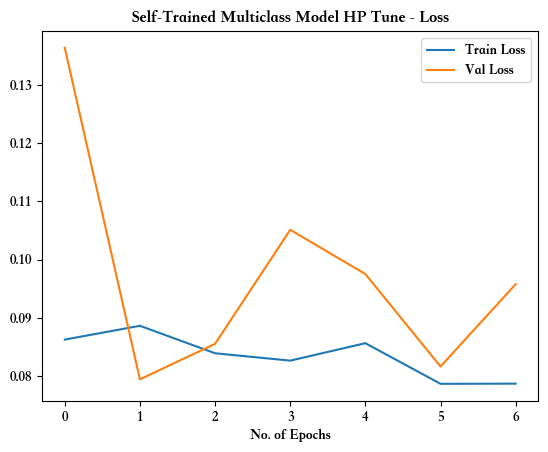

In [31]:
plt.plot(history_best.history['loss'], label='Train Loss')
plt.plot(history_best.history['val_loss'], label='Val Loss')
plt.title('Self-Trained Multiclass Model HP Tune - Loss')
plt.xlabel('No. of Epochs')
plt.legend();

The validation loss measures the difference between the predicted values and the actual values in the validation dataset. A lower validation loss indicates that the model's predictions are closer to the actual values. In this case, the validation loss is very close to the training loss, which means the model is performing well.

#### 1.7.2 Accuracy over training epochs

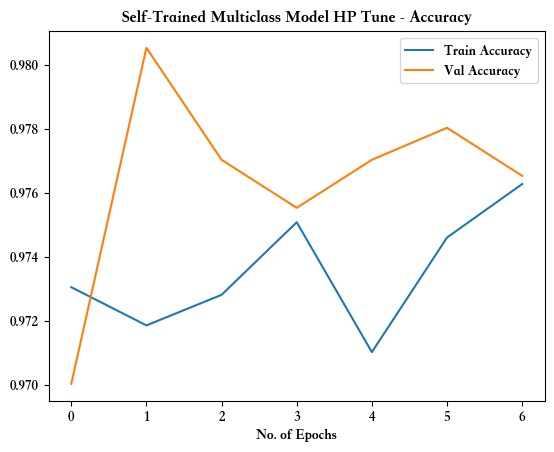

In [32]:
plt.plot(history_best.history['accuracy'], label='Train Accuracy')
plt.plot(history_best.history['val_accuracy'], label='Val Accuracy')
plt.title('Self-Trained Multiclass Model HP Tune - Accuracy')
plt.xlabel('No. of Epochs')
plt.legend();

The train accuracy is only slightly higher than the validation accuracy. There is very little evidence of overfitting, as such the model is able to generalize well to unseen data.

#### 1.7.3 AUC over training epochs

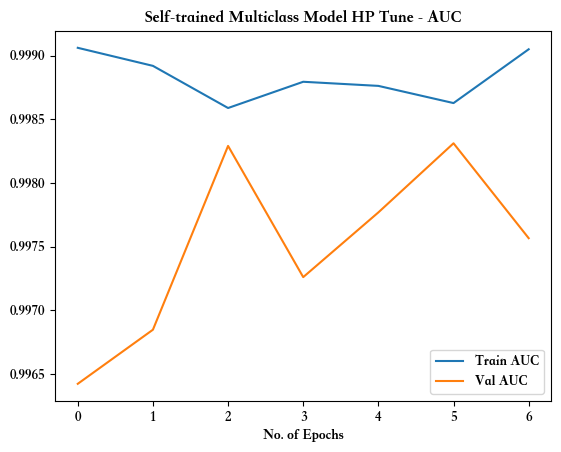

In [33]:
plt.plot(history_best.history['auc'], label='Train AUC')
plt.plot(history_best.history['val_auc'], label='Val AUC')
plt.title('Self-trained Multiclass Model HP Tune - AUC')
plt.xlabel('No. of Epochs')
plt.legend();

AUC is a measure of the ability of a classifier to distinguish between clsses. The higher the AUC, the better the model's performance, with a perfect AUC score being 1. In this aspect, the model is performing very well as it has the almost perfect score of 1.

#### 1.7.4 Summary of Metrics

We will compile these metrics to compare with the model before hyperparameters tuning.

In [34]:
summary_metrics = {}

summary_metrics['Train loss'] = history_best.history['loss'][-1]
summary_metrics['Val loss'] = history_best.history['val_loss'][-1]
summary_metrics['Train accuracy'] = history_best.history['accuracy'][-1]
summary_metrics['Val accuracy'] = history_best.history['val_accuracy'][-1]
summary_metrics['Train AUC'] = history_best.history['auc'][-1]
summary_metrics['Val AUC'] = history_best.history['val_auc'][-1]

print('Summary of metrics for Self-Trained Multiclass Model HP Tune')
print(summary_metrics)

Summary of metrics for Self-Trained Multiclass Model HP Tune
{'Train loss': 0.07865756750106812, 'Val loss': 0.09576504677534103, 'Train accuracy': 0.9762784838676453, 'Val accuracy': 0.9765352010726929, 'Train AUC': 0.9990500211715698, 'Val AUC': 0.997565746307373}


#### 1.7.5 Confusion Matrix

A confusion matrix shows the detailed breakdown of the model's predictions and the actual classes.

In [35]:
# Make predictions on the test data
predictions = best_model.predict(val_generator)

# Extract true labels
y_true = val_generator.classes

# Extract predicted labels
y_pred = np.argmax(predictions, axis=1)

  1/126 [..............................] - ETA: 16s

2024-05-11 04:02:32.853113: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'Placeholder/_0' with dtype int32
	 [[{{node Placeholder/_0}}]]


126/126 [==============================] - 7s 56ms/step


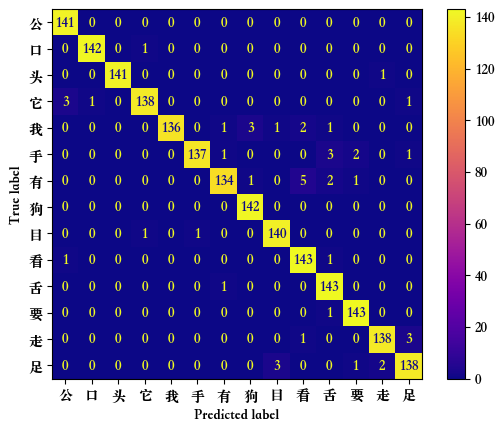

In [45]:
# Plot confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, 
            display_labels=class_labels)
disp.plot(cmap='plasma')
plt.show()

The diagonal line from top left to bottom right represents the true positives (data that was correctly predicted). The diagonal line is almost all yellow, which is the higher end of the spectrum. The number of data outside of the diagonal line is mostly under 3. This shows that the model is able to produce a highly accurate prediction.